## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, Iam working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

#### Part I - Probability

Import the libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query("group=='treatment' and landing_page!='new_page'").count()[0]

1965

In [7]:
df.query("group=='control' and landing_page!='old_page'").count()[0]

1928

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
df2=df.query("(group=='treatment' and landing_page=='new_page') or (group=='control' and landing_page=='old_page')")



In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

In [11]:
df2.shape[0]


290585

`3.` Use **df2** and the cells below to answer questions.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
 df2.loc[df2.user_id.duplicated(), 'user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2=df2.drop_duplicates(['user_id'])

In [16]:
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the  questions:
a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
conver_co=df2.query("group=='control'")['converted'].mean()
conver_co

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
conver_tr=df2.query("group=='treatment'")['converted'].mean()
conver_tr

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
len(df2.query( "landing_page=='new_page'"))/df2.shape[0]

0.5000619442226688

In [21]:
diff=conver_co-conver_tr
diff

0.0015782389853555567

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?

**1. The difference of converted ratio between control group and experiment group is only 0.15%, it is not significant to conclude that the new page is lead to more conversion than the old page
2.The probability that an individual landed a new page is roughly 0.5, so the chances of conversion both control group and experiment group are equal. this means that it is not possible for there to be a difference in conversion .**



<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?  We can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H{0}$: $p_{old}$ >=$p_{new}$
$H{1}$: $p_{old}$ <$p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
n_new=df2.query("landing_page=='new_page'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [25]:
n_old=df2.query("landing_page=='old_page'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1,p_new,n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.binomial(1,p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean()-old_page_converted.mean()

0.00085812125580210508

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [29]:
p_diffs = []
for _ in range(10000):
    new_page_converted=np.random.binomial(1,p_new,n_new)
    old_page_converted = np.random.binomial(1,p_old,n_old)
    diff=new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

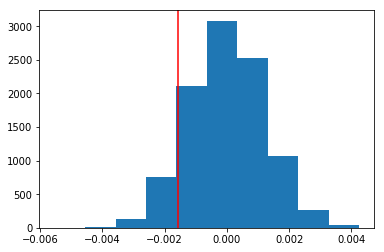

In [31]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
obs_diff=conver_tr-conver_co
plt.axvline(obs_diff, c='red')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
(p_diffs> obs_diff).mean()

0.90390000000000004

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The p-value calculated is 0.904, which is much greater than the typical $\alpha$ level of 0.05 . So we fail to reject the null, meaning  there is not sufficient evidence suggest that there is a difference between the two values.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("group == 'control'").shape[0]
n_new = df2.query("group == 'treatment'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new], alternative="smaller")
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [34]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(z_score))

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.905058312759
1.64485362695


**Result
The value of z-score from m is 1.31, which is less than the critical value of 1.64485362695. So we fail to reject the null hypothesis, meaning the new page conversion rate is higher than the old page. So, yes, the values align with those obtained during the bootstrapped hypothesis testing in parts j. and k**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df['intercept']=1
df[['ab_page', 'old_page']]=pd.get_dummies(df['landing_page'])
df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
log_mod=sm.Logit(df['converted'], df[['intercept','ab_page']])
results=log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366242
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294478
Model:                          Logit   Df Residuals:                   294476
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Sep 2018   Pseudo R-squ.:               8.680e-06
Time:                        19:13:25   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
                                        LLR p-value:                    0.1712
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9879      0.008   -248.305      0.000      -2.004      -1.972
ab_page       -0.0155      0.011     -1.368      0.171      -0.038       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  

**The P-value here (0.171) is above the an $\alpha$ level of 0.05, so we are still fail to reject the null. It's different because the logistic regression model is two tail test**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The gender of visitors, the time of period for visiting the web, the countries of the visitors might affect the conversion rate.  Under the same sample size adding additional terms into the regression model might be disadvantegeous because those terms might interact with each other, which could largely affect the coefficiency.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We need to read in the **countries.csv** dataset and merge together the datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  

In [42]:
df2=pd.read_csv('countries.csv')
df2.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [48]:
df_new = df2.set_index('user_id').join(df.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  


In [51]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [55]:
df_new['intercept']=1
df_new[['US','UK','CA']]=pd.get_dummies(df_new['country'])
df_new.head()


,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,US,UK,CA
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,0,1


In [57]:
log_mod=sm.Logit(df_new['converted'],df_new[['intercept', 'ab_page','US','UK'] ])
results=log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366238
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               294478
Model:                          Logit   Df Residuals:                   294474
Method:                           MLE   Df Model:                            3
Date:                Mon, 17 Sep 2018   Pseudo R-squ.:               2.068e-05
Time:                        19:43:51   Log-Likelihood:            -1.0785e+05
converged:                       True   LL-Null:                   -1.0785e+05
                                        LLR p-value:                    0.2158
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9885      0.009   -225.267      0.000      -2.006      -1.971
ab_page       -0.0155      0.011     -1.365      0.172      -0.038       0.007
US            -0.0357      0.027     -1.338      0.181      -0.088       0.017
UK             0.0093      0.013      0.702      0.483      -0.017       0.035
==============================================================================
"""

**Result:
Again, the p-value here are above showed that the $\alpha$ level of 0.05, so we are still fail to reject the null.**

**Conclusion:
According to the analysis performed from all above 3 tests, there is no significant evidence showing that the new page is better than the old page. So we will fail to reject the null hypothesis.**


In [33]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0